# Simple HHL with Estimator

This notebook demonstrates the simplest variant of HHL derived from Jack Morgan's code, using the Qiskit Estimator feature for measuring the fidelity of the solution.

* [Harrow, Hassidm, Lloyd](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.103.150502)
* [Lee, Joo, Lee](https://www.nature.com/articles/s41598-019-41324-9)
* [Morgan, Ghysels, Mohamadbagherpoor](https://arxiv.org/abs/2404.10103)
* [Jack Morgan's GitHub repository](https://github.com/jackhmorgan/Enhanced-Hybrid-HHL).

In [1]:
import numpy as np
from IPython.display import display, Markdown
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library import ExactReciprocal, HamiltonianGate, PhaseEstimation, StatePreparation
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2


def create_circuit(λ):
    # Problem setup: λ is a parameter for the 2x2 problem; the eigenvalues are 1-λ and λ.
    A = np.array([[ 1/2 , λ-1/2],[λ-1/2,  1/2 ]])
    b = np.array([[1.], [0.]])

    # Parameters of HHL circuit:
    π = np.pi
    maxλ = 1
    num_clock_qubits = 3
    hamiltonian_scale = abs((0.5-2**-num_clock_qubits)/maxλ)
    inversion_scale = 2*2**-num_clock_qubits

    # Components of HHL circuit:
    state_preparation = StatePreparation(Statevector(b))
    hamiltonian_simulation = HamiltonianGate(A, -2 * π * hamiltonian_scale)
    qpe = PhaseEstimation(num_clock_qubits, hamiltonian_simulation)
    eigenvalue_inversion = ExactReciprocal(num_clock_qubits, inversion_scale, neg_vals=True)

    # Build circuit:
    flag = QuantumRegister(1)
    clock_reg = QuantumRegister(num_clock_qubits, "clock")
    b_reg = QuantumRegister(qpe.num_qubits - num_clock_qubits, "b")
    c_reg = ClassicalRegister(1, "c1")
    circuit = QuantumCircuit(flag, clock_reg, b_reg, c_reg)
    circuit.append(state_preparation, b_reg)
    circuit.append(qpe, clock_reg[:] + b_reg[:])
    circuit.append(eigenvalue_inversion, clock_reg[::-1]+[flag[0]])
    circuit.measure(0, 0)
    with circuit.if_test((0,1)) as passed:
        circuit.append(qpe.inverse(), clock_reg[:] + b_reg[:])
    # num_b_qubits = int(np.log2(b.size))
    # q_reg = QuantumRegister(st_circuit.num_qubits - num_b_qubits, "q")
    # c2_reg = ClassicalRegister(1, "c2")
    # circuit.add_register(q_reg)
    # circuit.add_register(c2_reg)
    # ideal_x_statevector = get_ideal_x_statevector(A, b)
    # with circuit.if_test((0,1)) as passed:
    #     circuit.prepare_state(ideal_x_statevector, q_reg[:-1])
    #     circuit.append(st_circuit, range(-st_circuit.num_qubits, 0))
    #     circuit.measure(-1, c2_reg[0])
    return circuit

# Circuit Diagram

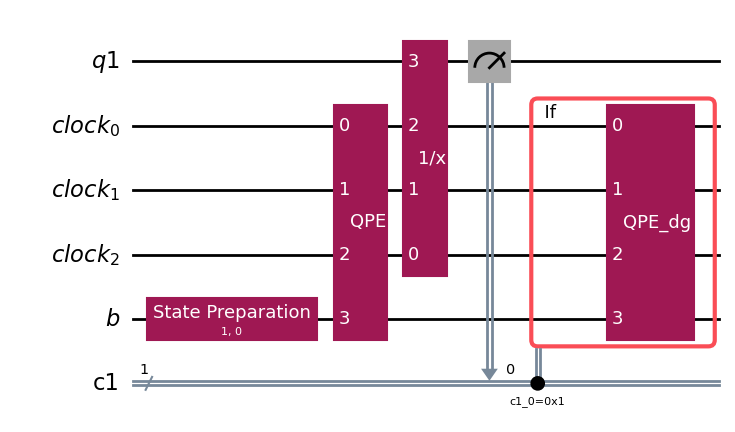

In [2]:
circuit = create_circuit(1/4)
display(Markdown("# Circuit Diagram"))
display(circuit.draw(output='mpl'))

# Fidelity as per Lee, Joo, Lee paper

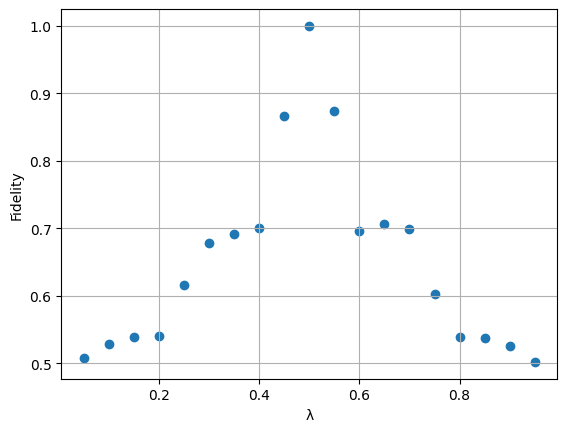

In [10]:
import matplotlib.pyplot as plt

def estimate_fidelity(λ):
    A = np.array([[ 1/2 , λ-1/2],[λ-1/2,  1/2 ]])
    b = np.array([[1.], [0.]])

    x = np.linalg.solve(A, b)
    x_norm = np.linalg.norm(x)
    x_state = x/x_norm

    ɑ = x_state[0][0]
    β = x_state[1][0]

    CI = 1/2
    CX = np.real(ɑ * np.conj(β))
    CY = - np.imag(ɑ * np.conj(β))
    CZ = 1/2*(np.abs(ɑ)**2 - np.abs(β)**2)

    circuit = create_circuit(λ)
    observable = SparsePauliOp.from_list([("IIIII", CI), ("XIIII", CX), ("YIIII", CY), ("ZIIII", CZ)])
    # observable = SparsePauliOp.from_list([("IIIII", CI), ("IIIIX", CX), ("IIIIY", CY), ("IIIIZ", CZ)])

    backend = AerSimulator()
    transpiled_circuit = transpile(circuit, backend)

    estimator = EstimatorV2()
    target = backend.target

    isa_observable = observable.apply_layout(layout=transpiled_circuit.layout)
    pub = (transpiled_circuit, [[isa_observable]])
    job = estimator.run(pubs=[pub])

    job_result = job.result()
    est = job_result[0].data.evs[0]
    # return np.sqrt(2*(1-est))
    return est

λ_values = [i/20 for i in range(1, 20)]
fidelity_values = [estimate_fidelity(λ) for λ in λ_values]

display(Markdown("# Fidelity as per Lee, Joo, Lee paper"))
plt.scatter(λ_values, fidelity_values)
plt.xlabel('λ')
plt.ylabel('Fidelity')
# plt.title('Fidelity vs λ')
plt.grid(True)
plt.show()
